# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.nlp import *

In [2]:
# df_bg_tmp = pd.read_csv('./Data/games_detailed_info.csv')
# df_rv_tmp = pd.read_csv('./Data/bgg-19m-reviews.csv')

df_bg_tmp = pd.read_csv('./Data/games-cleaned.csv')
df_rv_tmp = pd.read_csv('./Data/reviews-cleaned.csv')

# Data Cleaning & EDA (Board Games)

In [4]:
df_bg = df_bg_tmp.copy()
df_bg.shape

(4609, 20)

In [5]:
print('MISSING VALUES IN DATASET:')
print(df_bg.isna().sum().sort_values(ascending=False))

MISSING VALUES IN DATASET:
id               0
name             0
description      0
publisher        0
artist           0
designer         0
yearpublished    0
owned            0
minage           0
playingtime      0
maxplayers       0
minplayers       0
weight           0
mechanic         0
category         0
usersrated       0
avg_rating       0
geek_rating      0
rank             0
image            0
dtype: int64


เนื่องจากมีหลาย features ที่มี null ปริมาณมาก จึงทำการตัด feature ที่มี **null มากกว่า 50%**

In [6]:
df_bg = df_bg.dropna(axis=1,thresh=11000)
print('MISSING VALUES IN DATASET:')
print(df_bg.isna().sum().sort_values(ascending=False))

MISSING VALUES IN DATASET:
Series([], dtype: float64)


เปลี่ยนชื่อ features ให้เข้าใจง่ายและคัดเลือกเฉพาะ features ที่น่านำมาวิเคราะห์

In [7]:
df_bg['type'].value_counts()

KeyError: 'type'

ทุกเกมเป็น `type` เดียวกันหมด จึงตัดทิ้ง

In [ ]:
df_bg.rename(index=str, 
             columns={"primary": "name", "boardgamecategory": "category", "averageweight" : "weight", 
                      "Board Game Rank": "rank", "bayesaverage": "geek_rating", "average": "avg_rating","boardgamemechanic":"mechanic",
                      "boardgameartist": "artist", "boardgamedesigner":"designer", "boardgamepublisher": "publisher"}, inplace=True)

df_bg = df_bg[['id', 'name', 'rank', 'geek_rating', 'avg_rating', 'usersrated', 
               'category','mechanic', 'weight', 'minplayers', 'maxplayers', 
               'playingtime', 'minage',  'owned', 'yearpublished', 'designer', 
               'artist', 'publisher', 'description', 'image']]
df_bg.columns

พิจารณา `usersrated` และ `rank`

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.title('Users rated Plot')
sns.distplot(df_bg['usersrated'])

plt.subplot(1,2,2)
plt.title('Users rated Spread')
sns.boxplot(y=df_bg['usersrated'])

plt.show()

In [ ]:
df_bg['usersrated'].describe([0.25, 0.5, 0.6, 0.7, 0.75, 0.8])

1. กราฟที่ได้เป็น Right skewed distributions
1.เกม 70% ที่มี `usersrated` ต่ำกว่า 300

ทำการตัดข้อมูลที่มี `usersrated` ต่ำกว่า 300

In [ ]:
df_bg = df_bg[df_bg['usersrated'] >= 300]
df_bg['usersrated'].describe()

คัดเฉพาะเกมที่ `rank` ไม่เกิน 6000 (เกมที่แรงค์ต่ำเกินไปอาจเป็นเกมออกใหม่หรือไม่เป็นที่นิยม ซึ่งสามารถหาเล่นได้ยาก)

In [ ]:
df_bg = df_bg[df_bg['rank'] != 'Not Ranked'] 
df_bg = df_bg.astype({'rank': int}, errors='raise')

df_bg = df_bg[df_bg['rank'] <= 6000].copy()
df_bg.shape

In [ ]:
plt.figure(figsize=(20,6))
plt.title('Rank Plot')
sns.distplot(df_bg['rank'])
plt.show()

ข้อมูลที่ถูกตัดจาก`usersrated` มีเพียงเกมที่ `rank` มากกว่า 3000 เนื่องจากระบบ ranking ของ **BoardGameGeek** จัดตาม **Geek Rating** ซึ่งมีการใช้ dummy votes สำหรับเกมที่มีจำนวนคนให้คะแนนน้อย

ส่งผลให้เกมที่ได้คะแนนเยอะแต่มีจำนวนคนให้คะแนนน้อยมีแนวโน้มที่ **Geek Rating** น้อยกว่าเกมที่ได้คะแนนน้อยกว่าแต่มีจำนวนคนให้คะแนนเยอะ

ตัดข้อมูลที่ `category` หรือ `mechanic` เป็น null เนื่องจากไม่สามารถนำไปวิเคราะห์ได้

In [ ]:
df_bg = df_bg[df_bg['category'] == df_bg['category']]
df_bg = df_bg[df_bg['mechanic'] == df_bg['mechanic']] 
df_bg.shape

แทนที่ `artist` และ `designer` ที่เป็น null ให้เป็น `unknown`

In [ ]:
df_bg['artist'] = df_bg['artist'].fillna("'unknown'")
df_bg['designer'] = df_bg['designer'].fillna("'unknown'")

**Numerical Data**
* rank
* geek_rating
* avg_rating
* usersrated
* weight
* minplayers
* maxplayers
* playingtime
* minage
* owned
* yearpublished


In [ ]:
plt.figure(figsize=(15,6))
plt.title('Average Rating vs Geek Rating Plot')
sns.distplot(df_bg['avg_rating'])

sns.distplot(df_bg['geek_rating'])
plt.legend(['avg_rating', 'geek_rating'])
plt.show()

1. `avg_rating` เป็น normal distribution โดยมีค่าเฉลี่ยอยู่ที่ 7
1. `geek_rating` เป็น right skewed distribution เนื่องจากมีการดึงให้คะแนนอยู่ที่ 5.5

`avg_rating` มากกว่า `geek_rating`

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('minplayers')
plt.pie(df_bg['minplayers'].value_counts(), autopct='%.2f%%')
plt.legend(df_bg['minplayers'].value_counts().index)

vc = df_bg['maxplayers'].value_counts()
vc = vc[vc > 50]
plt.subplot(1,2,2)
plt.title('maxplayers')
plt.pie(vc, autopct='%.2f%%')
plt.legend(vc.index)
plt.show()

1. เกมส่วนใหญ่ต้องมีผู้เล่น**อย่างน้อย 2 คน** (63.48%)
1. เกมส่วนใหญ่ออกแบบมาสำหรับเล่น **4 คน** (40.05%)
1. เกมที่**ออกแบบมาสำหรับเล่นคนเดียว**มีน้อยมาก (1.39%) แต่เนื่องจากบางเกมมีกฏพิเศษสำหรับการเล่นคนเดียวทำให้เกมที่**สามารถเล่นคนเดียวได้**มีมากพอสมควร (22.78%)

In [ ]:
sns.pairplot(df_bg, x_vars=['geek_rating', 'avg_rating', 'usersrated'], y_vars='rank',size=5, aspect=1, kind='scatter')
plt.show()

1. `rank` จะแปรผกผันตาม `geek_rating`, `avg_rating` และ `usersrated`
1. `geek_rating` จะส่งผลต่อ `rank` โดยตรง

In [ ]:
sns.pairplot(df_bg, x_vars=['weight','minage'], y_vars='avg_rating',size=5, aspect=1, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

sns.pairplot(df_bg, x_vars=['minage'], y_vars='weight',size=5, aspect=1, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

1. เกมที่**ยาก**จะมีแนวโน้มที่จะได้**คะแนนสูง**
1. เกมสำหรับผู้เล่นที่**อายุเยอะ**จะมีแนวโน้มที่จะได้**คะแนนสูง**
1. เกมที่**ยาก**จะออกแบบมาสำหรับผู้เล่นที่**อายุเยอะ**

In [ ]:
plt.figure(figsize=(10,4))
plt.title('weight Plot')
sns.distplot(df_bg['weight'])
plt.show()

เกมส่วนใหญ่มี `weight` อยู่ที่ 1.0 - 3.0

In [ ]:
sns.pairplot(df_bg, x_vars=['usersrated', 'geek_rating'], y_vars='owned',size=5, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

เกมที่มี**คนเป็นเจ้าของ**เยอะจะมี**จำนวนคนให้คะแนน**เยอะ และมีแนวโน้มที่จะ**ได้คะแนน**มากขึ้นเล็กน้อย

In [ ]:
plt.figure(figsize=(10,4))
plt.title('yearpublished Plot')
sns.distplot(df_bg['yearpublished'])
plt.show()

In [ ]:
old_game = df_bg.loc[df_bg['yearpublished']<=0]
old_game

เกมเหล่านี้ส่วนใหญ่เป็นเกมกระดานแบบดั้งเดิมที่ล้าสมัยซึ่งเราไม่ได้พยายามแนะนำเกมกระดานดังกล่าว จึงทำการกรองเกมก่อนปี **1995** ทิ้ง เนื่องจากเป็นปีที่ **Eurogames เกมแรกได้รับความนิยมนอกยุโรป**

In [ ]:
df_bg = df_bg.loc[df_bg['yearpublished']>=1995]
df_bg.shape

In [ ]:
plt.figure(figsize=(8,6))
plt.title('yearpublished Plot')
sns.distplot(df_bg['yearpublished'])
plt.axvline(2009, ls='--', c='r')
plt.text(2008, 0.06, 'Kickstarter Launch', rotation='vertical', c='r');
plt.show()

อัตราการพัฒนาบอร์ดเกมสูงขึ้นเรื่อย ๆ โดยเฉพาะตั้งแต่ปี **2009** ซึ่งเป็นปีที่ **Kickstarter(บริษัทระดมทุน)เปิดตัว**

In [ ]:
sns.pairplot(df_bg, x_vars='yearpublished', y_vars='avg_rating',size=5, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

ยิ่งเป็นเกมที่**ออกใหม่**จะมีแนวโน้มที่**ได้คะแนนสูง**ขึ้น (อาจเป็นเพราะจำนวนคนให้คะแนนน้อยทำให้เกิด bias)

In [ ]:
df_bg_num = df_bg[['rank', 'geek_rating', 'avg_rating', 'usersrated', 'weight', 'minplayers', 'maxplayers',
                   'playingtime', 'minage', 'owned' ,'yearpublished']].copy()

plt.figure(figsize = (15, 15))
sns.heatmap(df_bg_num.corr(), annot = True, cmap="YlGnBu")
plt.show()

1. `rank` ถูกจัดอันดับตาม `geek_rating`
1. `geek_rating` จะขึ้นอยู่กับ `avg_rating`, `usersrated` และ `weight`
1. เกมที่ `weight` สูงจะถูกออกแบบให้ `minage` เยอะและต้องใช้ `playingtime` เยอะ
1. `usersrated` และ `owned` มีความใกล้เคียงกันมากและสามารถใช้แทนกันได้ จึงตัด `owned` ทิ้ง
1. `yearpublished` ที่ใหม่จะมีแนวโน้มที่ได้ `avg_rating` สูง 

**Categorical Data**
* category 
* mechanic 
* designer
* artist
* publisher
* description

In [ ]:
# df_bg_cat = df_bg[['category', 'mechanic']].copy()
df_bg['publisher'] = df_bg['publisher'].replace(', Ltd.','Ltd.', regex=True)
df_bg_cat = df_bg[['category', 'mechanic', 'designer', 'artist', 'publisher']].copy()


for col in df_bg_cat.columns:
    df_bg_cat[col] = df_bg_cat[col].apply(lambda x: x[1:len(x)-1].split(', '))

In [ ]:
cat_counts = df_bg_cat.explode('category')
cat_vc = cat_counts.groupby("category").size().sort_values(ascending=False)
cat_vc = cat_vc[cat_vc > 300]

mech_counts = df_bg_cat.explode('mechanic')
mech_vc = mech_counts.groupby("mechanic").size().sort_values(ascending=False)
mech_vc = mech_vc[mech_vc > 430]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('category')
plt.pie(cat_vc, autopct='%.2f%%')
plt.legend(cat_vc.index)

plt.subplot(1,2,2)
plt.title('mechanic')
plt.pie(mech_vc, autopct='%.2f%%')
plt.legend(mech_vc.index)
plt.show()

1. `category` ที่พบมากที่สุดคือ `Card Game` และ `Fantasy`
1. `mechaic` ที่พบมากที่สุดคือ `Hand Management` และ `Dice Rolling`

In [ ]:
des_counts = df_bg_cat.explode('designer')
des_vc = des_counts.groupby('designer').size().sort_values(ascending=False)
des_vc = des_vc[des_vc > 35]

art_counts = df_bg_cat.explode('artist')
art_vc = art_counts.groupby('artist').size().sort_values(ascending=False)
art_vc = art_vc[art_vc > 47]

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.subplots_adjust(right=1.5)
des_vc.plot(kind='barh', color='firebrick')
plt.gca().invert_yaxis()
plt.title('Top 10 Board Game Designers', fontsize=15)
plt.ylabel('designer')

plt.subplot(1,2,2)
art_vc.plot(kind='barh', color='chocolate')
plt.gca().invert_yaxis()
plt.title('Top 10 Board Game Artists', fontsize=15)
plt.ylabel('artists')
plt.show()

`artist` มี `unknown` จำนวนมาก เนื่องจากเกมเหล่านี้อาจเป็นเกมของการผลิตขนาดเล็ก

In [ ]:
pub_counts = df_bg_cat.explode('publisher')
pub_vc = pub_counts.groupby('publisher').size().sort_values(ascending=False)
pub_vc = pub_vc[pub_vc > 240]

plt.figure(figsize=(8,6))
pub_vc.plot(kind='barh', color='peachpuff')
plt.gca().invert_yaxis()
plt.title('Top 10 Board Game Publisher', fontsize=15)
plt.ylabel('publisher')
plt.show()

`Asmodee` เผยแพร่เกมเป็นจำนวนมากที่สุด เนื่องจากเป็นหนึ่งในผู้เผยแพร่รายใหญ่ที่สุดและยังทำให้เกมกระดานหลายเกมเป็นแบบ digital ทำให้ชื่อเสียงของพวกเขาเพิ่มมากขึ้น

# Data Cleaning & EDA (Board Games)

In [ ]:
df_rv = df_rv_tmp.copy()
df_rv.head()

In [ ]:
df_rv.shape

ตัดรีวิวที่ `name` ไม่ได้อยู่ใน `df_bg` 

In [ ]:
df_rv = df_rv[df_rv['name'].isin(df_bg['name'])]
df_rv = df_rv[['user', 'name', 'rating', 'comment']]
df_rv.shape

In [ ]:
df_rv['rating'].describe()

ตัดข้อมูลที่ `rating` น้อยกว่า 1

In [ ]:
df_rv = df_rv[df_rv['rating']>=1]
df_rv['rating'].describe()

ตัดข้อมูลที่ไม่มี `user`

In [ ]:
df_rv = df_rv[df_rv['user'] == df_rv['user']]

ตัด `user` ที่มีการให้คะแนนน้อยกว่า 100 เกม

In [ ]:
cv = df_rv['user'].value_counts()
df_rv = df_rv[df_rv['user'].isin(cv[cv >= 450].index)]
df_rv.shape

In [ ]:
plt.figure(figsize=(8,6))
plt.title('user rating Plot')
sns.distplot(df_rv['rating'])
plt.show()

ผู้ใช้ส่วนใหญ่ให้ `rating` ที่ 6-8

In [ ]:
not_comment = df_rv.isna().sum().sort_values(ascending=False)[0]

d = {"doesn't comment": not_comment, 'comment': df_rv.shape[0]-not_comment}    
ser_comment = pd.Series(data=d, index=["doesn't comment", 'comment'])
ser_comment

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title('users comment')
plt.pie(ser_comment, autopct='%.2f%%')
plt.legend(ser_comment.index)
plt.show()

มีผู้ใช้ที่ `comment` เพียง 26% จากรีวิวทั้งหมด (5 แสนคนจาก 2 ล้านคน)

In [3]:
df_bg_tmp = pd.read_csv('./Data/games-cleaned.csv')

In [4]:
df_bg = df_bg_tmp.copy()

In [58]:
bg_nlp = df_bg[['name', 'description']].copy()
bg_nlp = setup(bg_nlp, target = 'description', custom_stopwords = ['player', 'card', 'play', 'game'], session_id=42)

Description,Value
session_id,42
Documents,4609
Vocab Size,17167
Custom Stopwords,True


In [59]:
lda = create_model('lda', num_topics = 6, multi_core = True)
lda_results = assign_model(lda)
lda_results.head()

,name,description,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Dominant_Topic,Perc_Dominant_Topic
0,Pandemic,pandemic several virulent disease break simult...,0.358507,0.001421,0.001414,0.362391,0.105321,0.170947,Topic 3,0.36
1,Carcassonne,draw place tile piece southern french landscap...,0.045815,0.944289,0.002476,0.002463,0.002467,0.002490,Topic 1,0.94
2,Catan,formerly try dominant settlement city road tur...,0.504997,0.491770,0.000804,0.000808,0.000806,0.000815,Topic 0,0.50
3,7 Wonders,leader great city ancient world gather resourc...,0.673569,0.288905,0.020766,0.013468,0.001650,0.001642,Topic 0,0.67
4,Dominion,parent ruler small pleasant kingdom river ever...,0.343098,0.145577,0.001635,0.001636,0.004951,0.503103,Topic 5,0.50


In [60]:
lda_results['Dominant_Topic'].value_counts()

Topic 0    1435
Topic 1    1022
Topic 5     987
Topic 4     733
Topic 2     251
Topic 3     181
Name: Dominant_Topic, dtype: int64

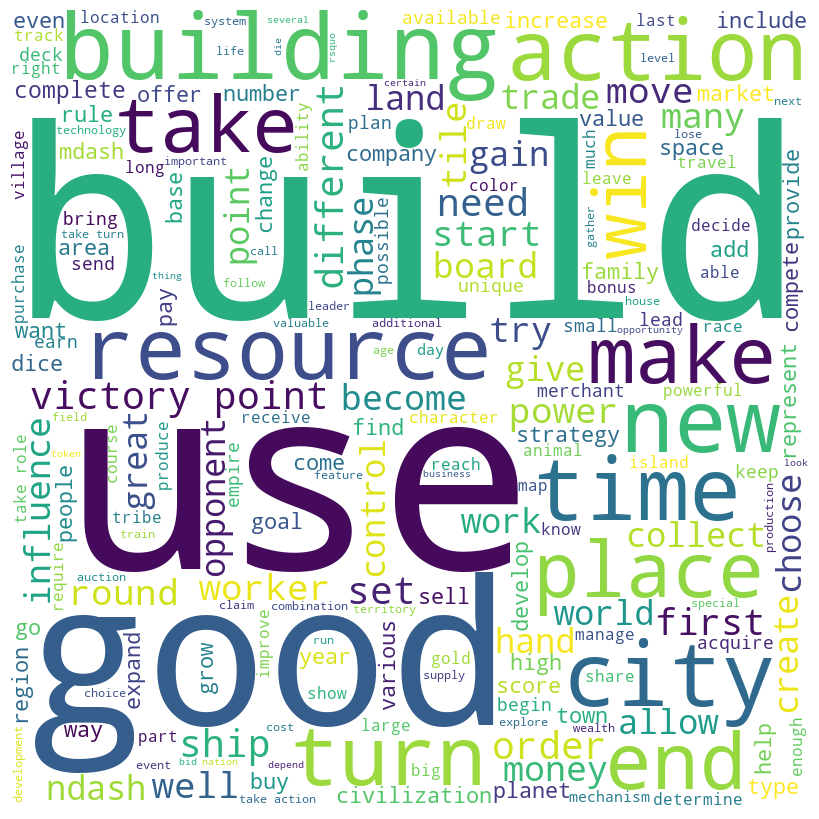

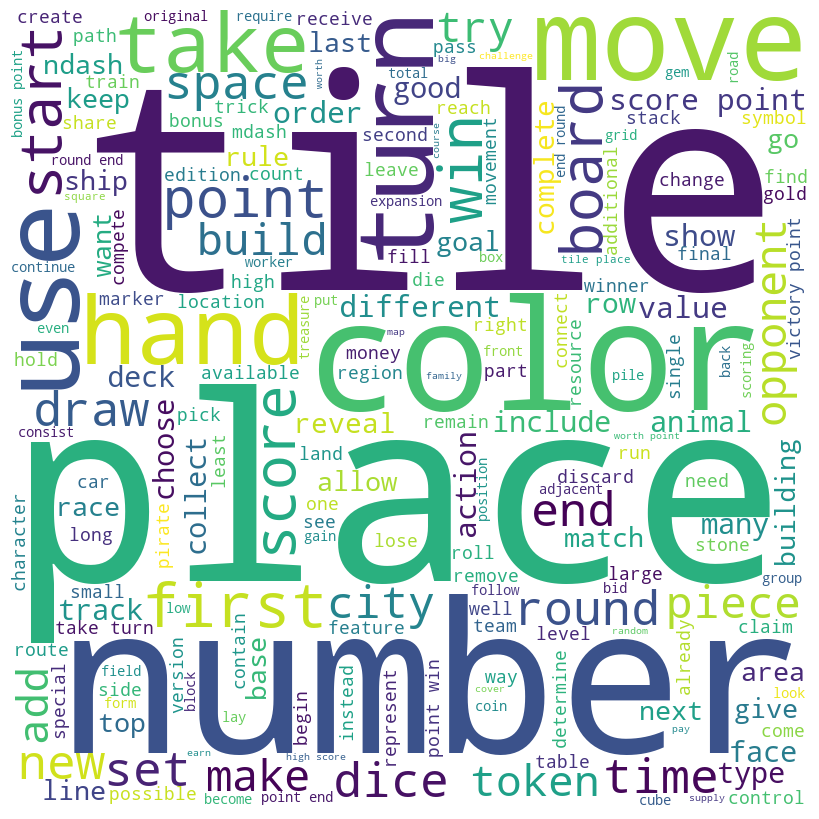

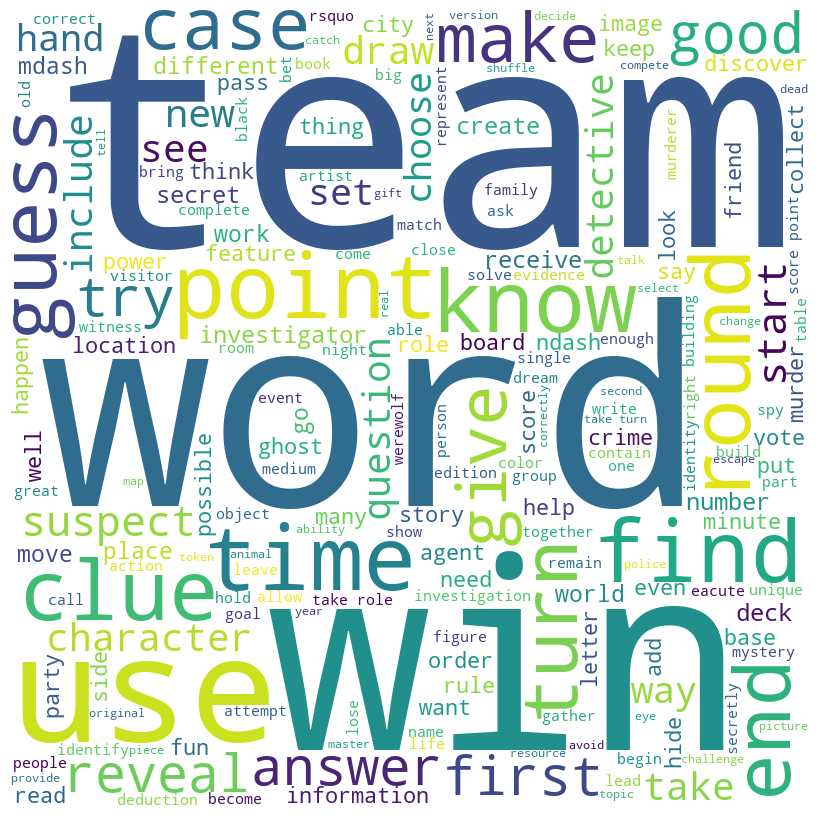

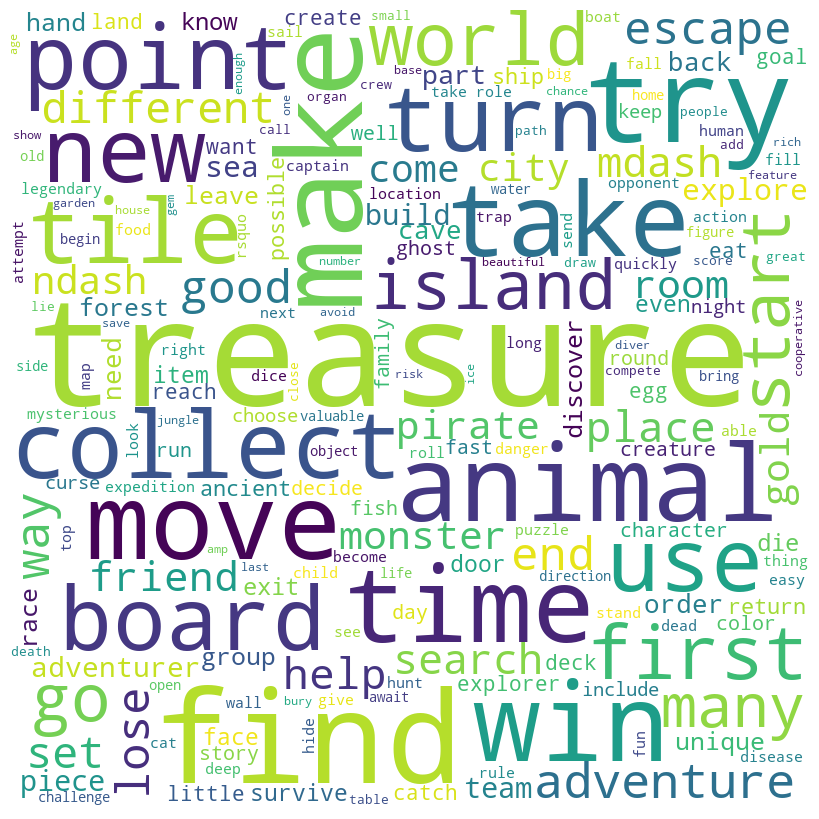

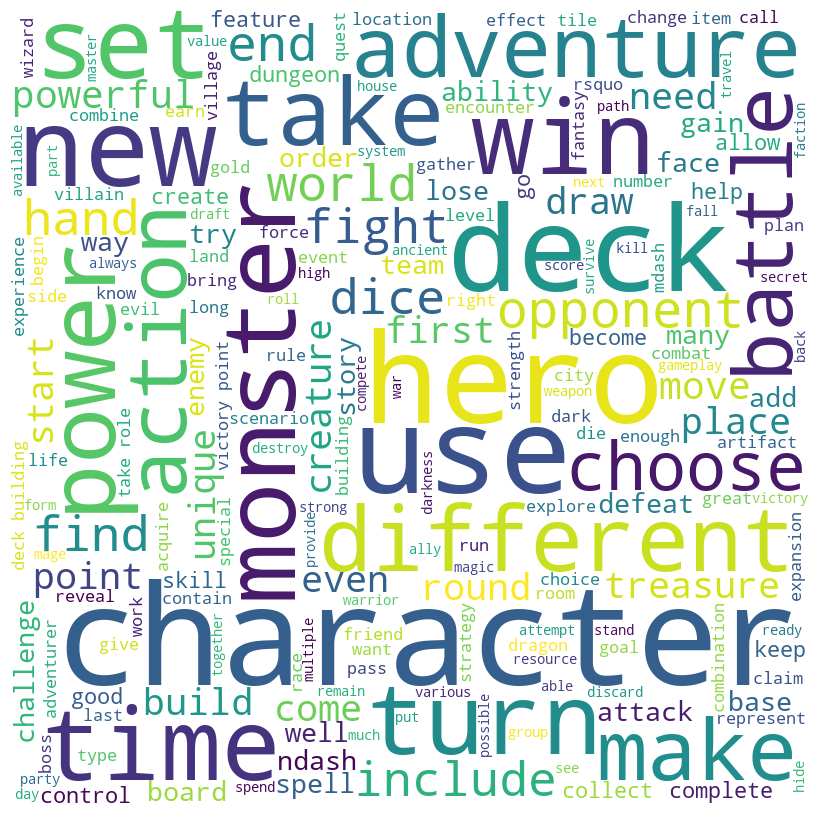

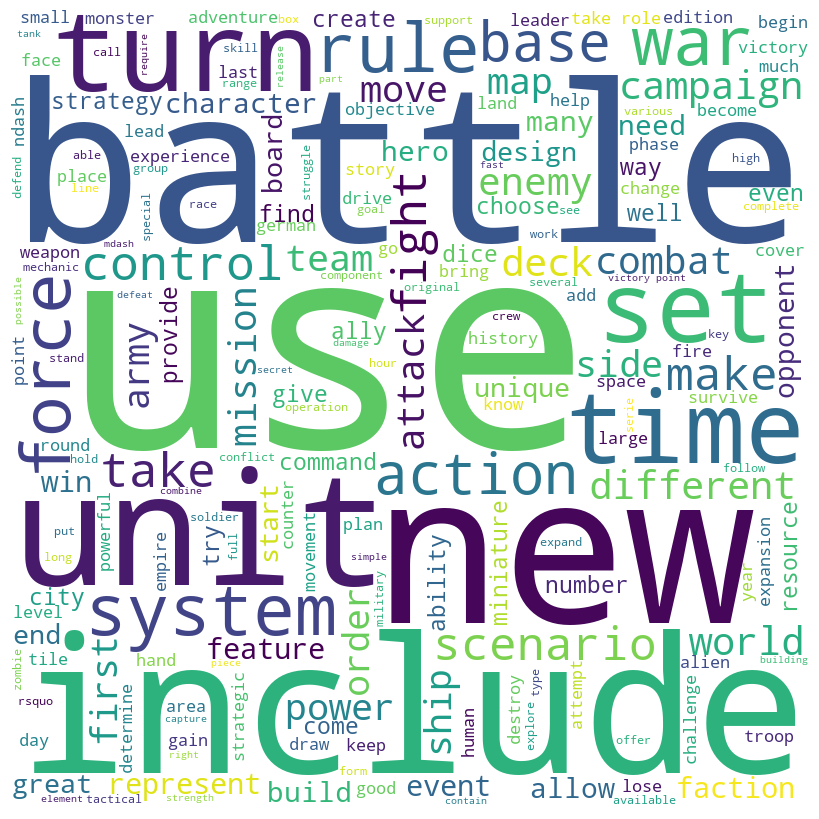

In [67]:
for i in range(6):
    plot_model(lda, plot = 'wordcloud', topic_num=f'Topic {i}')

In [62]:
# plot_model(lda, plot = 'topic_distribution')

In [63]:
# evaluate_model(lda)

# Save clean data to CSV

In [64]:
# df_bg.to_csv('games-cleaned.csv', index=False)
# df_rv.to_csv('reviews-cleaned.csv', index=False)